In [1]:
import torch

data = torch.load("stgcn_dataset.pt", map_location="cpu")
print(data.keys())


dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'graph'])


C:\Users\User\AppData\Local\Temp\ipykernel_11452\2671873823.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("stgcn_dataset.pt", map_location="cpu")


In [2]:
print(data["X_train"].shape)  # (N, C, T, V, 1)
print(data["y_train"].shape)  # (N,)
print(data["graph"].shape)    # (3, 17, 17)


torch.Size([714, 3, 30, 17, 1])
torch.Size([714])
torch.Size([3, 17, 17])


In [3]:
X_train = data["X_train"]   # (N, C, T, V, 1)
y_train = data["y_train"]
X_test  = data["X_test"]
y_test  = data["y_test"]
A       = data["graph"]      # (3, V, V)

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split

class STGCNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dataset = STGCNDataset(X_test, y_test)
test_size = len(test_dataset)
val_size  = test_size // 2
final_test_size = test_size - val_size

val_dataset, final_test_dataset = random_split(
    test_dataset,
    [val_size, final_test_size],
    generator=torch.Generator().manual_seed(42)  # 🔒 reproducible
)

train_loader = DataLoader(
    STGCNDataset(X_train, y_train),
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False
)

test_loader = DataLoader(
    final_test_dataset,
    batch_size=16,
    shuffle=False
)


เพิ่ม Dropout ใน TCN

ช่วยลด val loss แกว่ง

In [5]:
import torch
import torch.nn as nn

# ---------- Graph Convolution ----------
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.A = nn.Parameter(
            torch.tensor(A, dtype=torch.float32),
            requires_grad=False
        )  # (K, V, V)

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (N*M, C, T, V)
        A = self.A.to(x.device)
        x = torch.einsum("nctv,kvw->nctw", x, A)
        x = self.conv(x)
        return x


# ---------- ST-GCN Block ----------
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, dropout=0.0):
        super().__init__()

        self.gcn = GraphConv(in_channels, out_channels, A)

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(9, 1),
                padding=(4, 0),
                stride=(stride, 1)
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout)   # dropout อยู่ตรงนี้
        )

        # residual
        if in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)
                ),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)
        x = self.tcn(x)
        return self.relu(x + res)


# ---------- ST-GCN Model ----------
class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, A):
        super().__init__()

        self.layer1 = STGCNBlock(in_channels, 64,  A, stride=1, dropout=0.1)
        self.layer2 = STGCNBlock(64, 128, A, stride=2, dropout=0.3)
        self.layer3 = STGCNBlock(128, 256, A, stride=2, dropout=0.3)

        self.dropout = nn.Dropout(0.5)  # ก่อน fc
        self.fc = nn.Linear(256, num_class)

    def forward(self, x):
        # x: (N, C, T, V, M)
        N, C, T, V, M = x.shape

        # -------- Input normalization (สำคัญมาก) --------
        x[:, 0:2] = x[:, 0:2] - x[:, 0:2].mean(dim=3, keepdim=True)
        x[:, 0:2] = x[:, 0:2] / (x[:, 0:2].std() + 1e-6)

        # flatten person
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        x = x.view(N * M, C, T, V)

        # ST-GCN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # global average pooling
        x = x.mean(dim=2).mean(dim=2)   # (N*M, C)

        # restore person
        x = x.view(N, M, -1).mean(dim=1)

        x = self.dropout(x)
        return self.fc(x)


In [6]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = STGCN(3, y_train.max().item()+1, A).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


C:\Users\User\AppData\Local\Temp\ipykernel_11452\4124120401.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(A, dtype=torch.float32),


In [7]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [8]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            out = model(X)
            loss = criterion(out, y)

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(loader)
    acc = correct / total

    return avg_loss, acc


In [9]:
history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "lr": []

}


In [10]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return True   # improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
            return False


LR ยังสูงเกินสำหรับ + dropout

In [11]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,              # 🔻 ลด LR
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    verbose=True
)


c:\Users\User\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
num_epochs = 100
early_stopping = EarlyStopping(patience=10)

best_model_state = None

for epoch in range(1, num_epochs + 1):

    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    history["lr"].append(current_lr)

    print(
        f"Epoch {epoch:03d} | "
        f"lr={current_lr:.2e} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_acc={val_acc*100:.2f}%"
    )

    improved = early_stopping.step(val_loss)
    if improved:
        best_model_state = model.state_dict()

    if early_stopping.stop:
        print("Early stopping triggered")
        break


Epoch 001 | lr=3.00e-04 | train_loss=1.2068 | val_loss=1.0733 | val_acc=63.45%
Epoch 002 | lr=3.00e-04 | train_loss=0.8854 | val_loss=0.9556 | val_acc=62.46%
Epoch 003 | lr=3.00e-04 | train_loss=0.7821 | val_loss=0.9425 | val_acc=64.57%
Epoch 004 | lr=3.00e-04 | train_loss=0.7069 | val_loss=0.9168 | val_acc=69.19%
Epoch 005 | lr=3.00e-04 | train_loss=0.6749 | val_loss=0.7389 | val_acc=73.11%
Epoch 006 | lr=3.00e-04 | train_loss=0.6228 | val_loss=0.7111 | val_acc=76.33%
Epoch 007 | lr=3.00e-04 | train_loss=0.5669 | val_loss=0.7459 | val_acc=72.41%
Epoch 008 | lr=3.00e-04 | train_loss=0.5082 | val_loss=0.6429 | val_acc=79.41%
Epoch 009 | lr=3.00e-04 | train_loss=0.4647 | val_loss=0.5756 | val_acc=80.25%
Epoch 010 | lr=3.00e-04 | train_loss=0.4238 | val_loss=0.6833 | val_acc=76.47%
Epoch 011 | lr=3.00e-04 | train_loss=0.4316 | val_loss=0.6493 | val_acc=75.63%
Epoch 012 | lr=3.00e-04 | train_loss=0.3868 | val_loss=0.9308 | val_acc=70.03%
Epoch 013 | lr=3.00e-04 | train_loss=0.3827 | val_lo

In [13]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

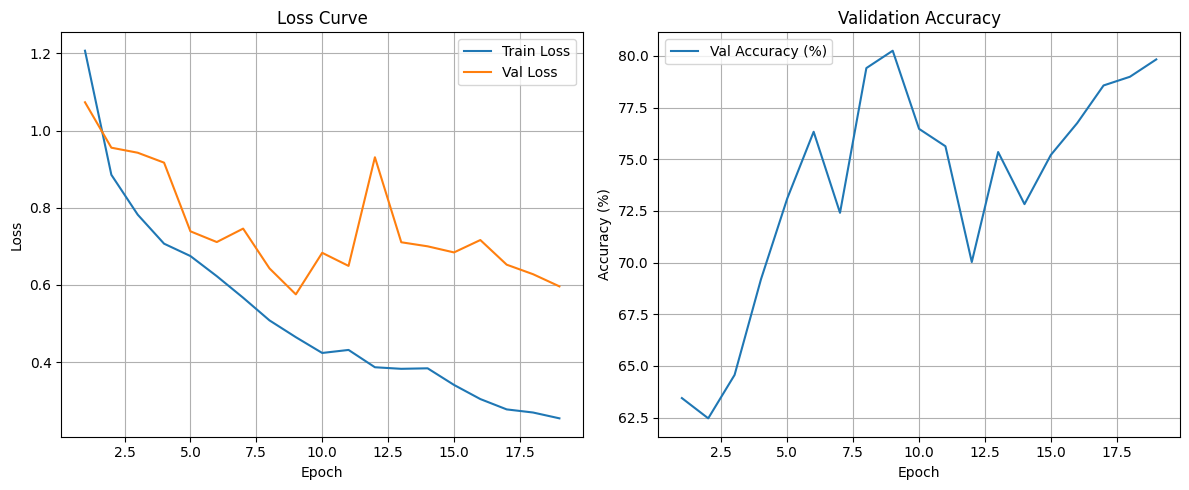

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in history["val_acc"]], label="Val Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


ดูจากกราฟแล้ว:

Train loss ลดลงต่อเนื่อง → โมเดลเรียนรู้ได้จริง ✔️

Val loss ลดช่วงแรก แต่แกว่งและไม่ลดตาม train → เริ่มมีสัญญาณ overfitting เล็ก–กลาง

Val accuracy ขึ้นเรื่อย ๆ จบแถว ~78–79% → ใช้งานได้ แต่ยังไม่สุด 🚀

สรุปภาพรวม

โมเดลเรียนรู้ดี แต่ยัง generalize ได้ไม่เต็มที่

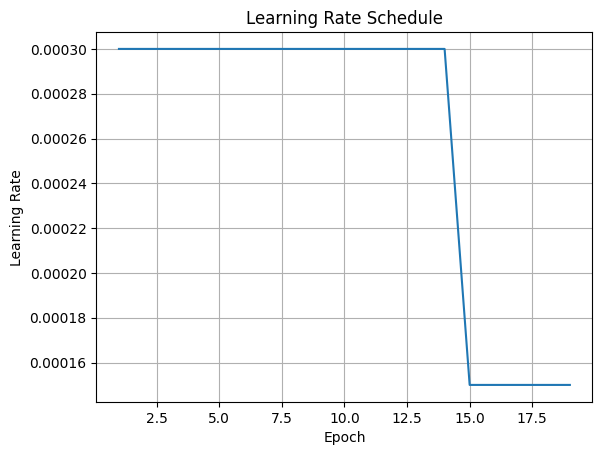

In [15]:
plt.figure()
plt.plot(epochs, history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()


In [16]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

Final Test Accuracy: 79.83%


In [17]:
torch.save({
    "model_state": model.state_dict(),
    "history": history,
}, "stgcn_trained_v2.pt")
